Stochastic Variational Inference for Scalability with SVGP
--

* Mark van der Wilk, 2016 *
* edits by James Hensman, 2016*

One of the main criticisms of Gaussian processes is their scalability to large datasets. In this notebook, we illustrate how to use the state-of-the-art Stochastic Variational Gaussian Process (SVGP) (*Hensman, et. al. 2013*) to overcome this problem. 

In [1]:
%matplotlib inline
import sys
import numpy as np
import numpy.random as rnd
import time
import gpflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Generating data:
For this notebook example, we generate 10000 noisy observations from a test function:
$$
f(x) = \sin(3\pi x) + 0.3\cos(9\pi x) + \frac{\sin(7 \pi x)}{2}
$$

In [2]:
def func(x):
    return np.sin(x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14)

N = 10000 # Number of training observations

X = rnd.rand(N, 1) * 2 - 1 # X values
Y = func(X) + 0.2 * rnd.randn(N, 1) # Noisy Y values

We plot the data along with the noiseless generating function:

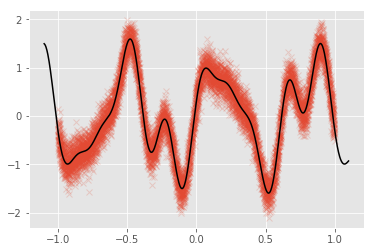

In [3]:
plt.plot(X, Y, 'x', alpha=0.2)
D = X.shape[1]
Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
Yt = func(Xt)
plt.plot(Xt, Yt, c='k');

## Building the model:
The main idea behind SVGP is to approximate the true GP posterior with a GP conditioned on a small set of inducing values. This smaller set can be thought of as summarising the larger dataset. For this example, we will select a set of 50 inducing locations that are initialised from the training dataset:

In [4]:
M = 50 # Number of inducing locations

def init():
    kern = gpflow.kernels.RBF(D, 1)
    Z = X[:M, :].copy() # Initialise inducing locations
    m = gpflow.models.SVGP(X, Y, kern, gpflow.likelihoods.Gaussian(), Z, minibatch_size=len(X))
    return m

m = init()

## Likelihood computation: Batch vs. Minibatch
First we showcase the model's performance using the whole dataset to compute the ELBO.

In [5]:
%%timeit
m.compute_log_likelihood()

19.5 ms ± 276 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We can speed up this calculation by using minibatches of the data.

In [6]:
ground_truth = m.compute_log_likelihood()
m.X.set_batch_size(100)
m.Y.set_batch_size(100)

In [7]:
%%timeit
m.compute_log_likelihood()

2.48 ms ± 91.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Stochastical estimation of ELBO
The minibatch estimate should be an unbiased estimator of the `ground_truth`. Here we show a histogram of the value from different evaluations, together with its mean and the ground truth. The small difference between the mean of the minibatch estimations and the ground truth shows that the minibatch estimator is working as expected.

In [8]:
evals = [m.compute_log_likelihood() for _ in range(100)]

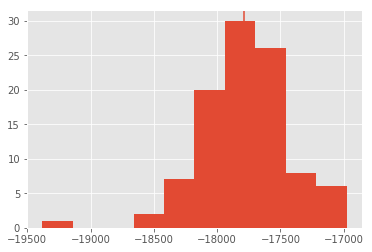

In [9]:
plt.hist(evals)
plt.axvline(ground_truth)

### Minibatches speed up computation
The use of using minibatches is that it decreases the time needed to make an optimisation step, since estmating the objective is cheaper. Here we plot the change in time required with the size of the minibatch. We see that smaller minibatches result in a cheaper estimate of the objective.

In [10]:
mbps = np.logspace(-2, 0, 10)
times = []
objs = []
for mbp in mbps:
    batchsize = int(len(X) * mbp)
    m.X.set_batch_size(batchsize)
    m.Y.set_batch_size(batchsize)
    start_time = time.time()
    objs.append([m.compute_log_likelihood() for _ in range(20)])
    times.append(time.time() - start_time)

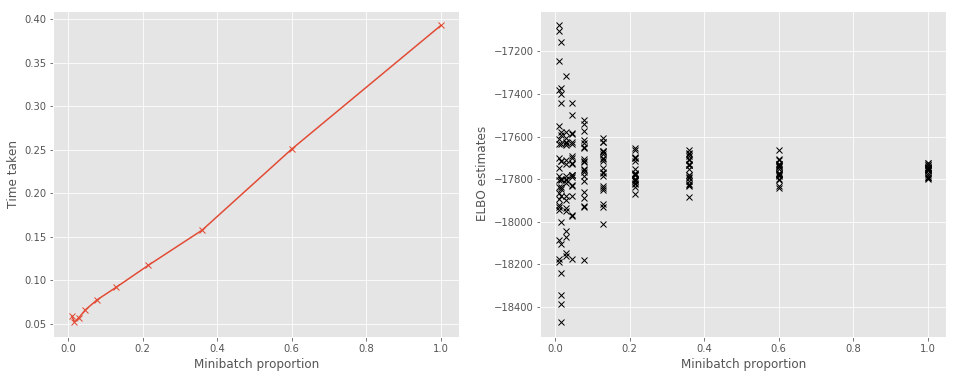

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(mbps, times, 'x-')
ax1.set_xlabel("Minibatch proportion")
ax1.set_ylabel("Time taken")

ax2.plot(mbps, np.array(objs), 'kx')
ax2.set_xlabel("Minibatch proportion")
ax2.set_ylabel("ELBO estimates");

### Running stochastic optimization

Text(0.5, 1.0, 'Predictions before training')

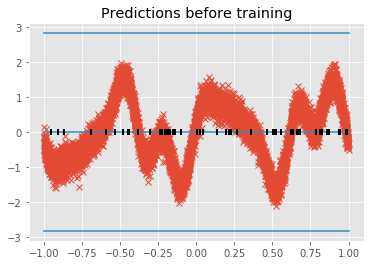

In [12]:
def plot():
    pX = np.linspace(-1, 1, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    plt.plot(X, Y, 'x')
    line, = plt.plot(pX, pY, lw=1.5)
    col = line.get_color()
    plt.plot(pX, pY+2*pYv**0.5, col, lw=1.5)
    plt.plot(pX, pY-2*pYv**0.5, col, lw=1.5)
    plt.plot(m.feature.Z.value, np.zeros(m.feature.Z.value.shape), 'k|', mew=2)

plot()
plt.title("Predictions before training")

In [13]:
class Logger(gpflow.actions.Action):
    def __init__(self, model):
        self.model = model
        self.logf = []
        
    def run(self, ctx):
        if (ctx.iteration % 10) == 0:
            likelihood = - ctx.session.run(self.model.likelihood_tensor)
            self.logf.append(likelihood)

In [14]:
m.X.set_batch_size(100)
m.Y.set_batch_size(100)

m.feature.trainable = False

def run_adam(model, iterations):
    adam = gpflow.train.AdamOptimizer().make_optimize_action(model)
    logger = Logger(model)
    actions = [adam, logger]
    loop = gpflow.actions.Loop(actions, stop=iterations)()
    model.anchor(model.enquire_session())
    return logger

logger = run_adam(m, gpflow.test_util.notebook_niter(10000))

Text(0, 0.5, 'ELBO')

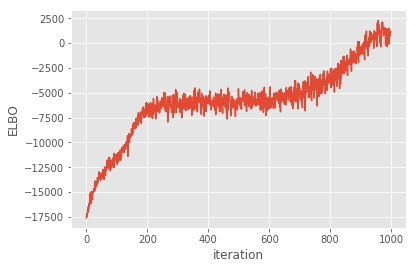

In [15]:
plt.plot(-np.array(logger.logf))
plt.xlabel('iteration')
plt.ylabel('ELBO');

Text(0.5, 1.0, 'Predictions after training')

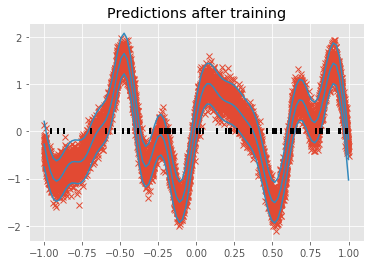

In [16]:
plot()
plt.title("Predictions after training")

### References:
Hensman, James, Nicolo Fusi, and Neil D. Lawrence. "Gaussian processes for big data." Uncertainty in Artificial Intelligence (2013).